---

# Jigsaw Toxic Comment Classification

---

### **Introduction**

The work carried out in this notebook focused on the [Jigsaw Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) hosted on [Kaggle](https://www.kaggle.com/). The task consists of a **Multilabel text classification** problem where a given toxic comment, needs to be classified into one or more categories out of the following list:
- `toxic`
- `severe_toxic`
- `obscene`
- `threat`
- `insult`
- `identity_hate`

For instance, if the comment is `toxic` and `obscene`, then for both those headers the value will be `1` and for the others it will be `0`.

### **Data**

- I've used the [Jigsaw toxic data](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data) prived by the competition
- I've referring only to the following csv files from the data dump: `train.csv`, `test.csv`, `test_labels.csv`
- Now that the competition has ended, the labels for the test set have been provided. This will enable us to conduct inference and assess the performance of each tested model.

### **Models**
I employed three distinct models to address the challenge:
- **MODEL I**: a baseline approach that utilized a **Bidirectional Long Short-Term Memory (LSTM)** network with **embeddings trained from scratch**.
- **MODEL II**: a variation of the baseline approach that incorporated **Glove's pre-trained embeddings** with the Bidirectional LSTM architecture.
- **MODEL III**: the well-known **BERT model**, which is capable of producing state-of-the-art results on a range of NLP tasks including text classification.

By utilizing these three models, I aimed to determine which approach would yield the most effective results for this particular task.

### **Evaluation metric**
For the evaluation of my models in the Toxic Comment Challenge competition, I opted to use the **macro-averaged F1 score** as the reference metric, rather than AUC-ROC as recommended by the competition guidelines. I believe F1 to be a more appropriate metric for the following reasons: 
- the F1 score is a more comprehensive metric that takes both precision and recall into account and provides a more nuanced assessment of the model's performance across all the different classes. This is particularly important in the Toxic Comment Challenge, where identifying and categorizing multiple types of toxic comments is crucial.
- Moreover, the macro-averaged F1 score does not take class imbalance into account, which ensures that every class is given equal weight independently of its proportion. This is important in imbalanced datasets where one or more classes may be significantly underrepresented.
- In contrast, AUC-ROC can be misleading in case of imbalanced data, as it only considers the overall performance of the model without taking into account class imbalance. 
- By prioritizing F1 over AUC-ROC, I aimed to ensure that my models were optimized for real-world applications.

---

### **Flow of the Notebook**

The notebook will be divided into seperate sections to provide a organized walk through for the process used, as follows:

1. [Installing Dependencies and importing libraries](#section01)
2. [Loading the data](#section02)
3. [Exploratory Data Analysis](#section03)
4. [Text preprocessing](#section04)
5. [Train, validation and test splits](#section05)
6. [MODEL I - Baseline](#section06)
7. [MODEL II - Glove](#section07)
8. [MODEL III - BERT](#section08)
9. [Comparison of models performance](#section09)
10. [Conclusion and future work](#section10)

---

<a id='section01'></a>
# 1. Installing Dependencies and importing libraries


In [ ]:
!pip install tensorflow_text
!pip install -q tf-models-official==2.11.0
!pip install tensorflow-addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/toxicity/'

Mounted at /content/drive


In [ ]:
# Importing Essential Libraries

# import the os module for operating system related functionalities
import os     
    
# import the re module for regular expression operations
import re 

# import the shutil module for high-level file operations
import shutil 

# import the pandas module for data manipulation and analysis
import pandas as pd   

# import the TensorFlow module for deep learning
import tensorflow as tf    

# import the NumPy module for numerical operations
import numpy as np    

# import the matplotlib module for data visualization
import matplotlib.pyplot as plt   

# import the TensorFlow Addons module for additional functionality
import tensorflow_addons as tfa   

# import the TensorFlow Hub module for pre-trained models
import tensorflow_hub as hub   

# import the TensorFlow Text module for text preprocessing and manipulation
import tensorflow_text as text   

# import the Natural Language Toolkit (nltk) module for natural language processing
import nltk   

# import the word_tokenize function from the nltk.tokenize module for tokenizing words
from nltk.tokenize import word_tokenize   

# import the stopwords corpus from the nltk.corpus module for removing stop words
from nltk.corpus import stopwords   

# import the WordNetLemmatizer class from the nltk.stem module for lemmatizing words
from nltk.stem import WordNetLemmatizer   

# import the Sequential class from the tensorflow.keras.models module for building sequential models
from tensorflow.keras.models import Sequential   

# import various layers from the tensorflow.keras.layers module for building neural networks
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding   

# import EarlyStopping and ReduceLROnPlateau callbacks from the keras.callbacks module for monitoring and optimizing training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau   

# import the Tokenizer class from the keras.preprocessing.text module for tokenizing text
from keras.preprocessing.text import Tokenizer   

# import the WordCloud class and STOPWORDS from the wordcloud module for generating word clouds
from wordcloud import WordCloud, STOPWORDS   

# import the optimization module from the official.nlp package for optimizing the TensorFlow model's performance
from official.nlp import optimization   

# Set the logging level of TensorFlow's default logger to "ERROR" to suppress verbose output during training and inference
tf.get_logger().setLevel('ERROR')   


<a id='section02'></a>
# 2. Loading the data

## Train data

In [ ]:
#Load Training Dataset
df_train = pd.read_csv(os.path.join(path,'train.csv', 'train.csv'))

In [ ]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df_train.shape

(159571, 8)

## Test data
- In the Toxic Comment Challenge dataset, the test set labels contain many -1 values because those samples were not included in the final evaluation of the competition. 

- Therefore, in order to properly evaluate the performance of a model on the test set, it is necessary to remove the samples with -1 labels and only use the samples with actual labels for evaluation


In [ ]:
# Loading Testing Dataset
test_samples = pd.read_csv(os.path.join(path,'test.csv', 'test.csv'))
test_labels = pd.read_csv(os.path.join(path,'test_labels.csv', 'test_labels.csv'))
df_test = pd.merge(test_samples, test_labels, on="id")

In [ ]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [ ]:
df_test.shape

(153164, 8)

In [ ]:
# removing sample with labels equal to -1
df_test = df_test.loc[df_test['toxic'] >= 0]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [ ]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [ ]:
df_test.shape

(63978, 8)

<a id='section03'></a>
# 3. Exploratory Data Analysis
Exploratory Data Analysis (EDA) is a crucial step in any data analysis project, including text classification tasks like the Toxic Comment Challenge. By performing EDA on the dataset, we can gain important insights into the nature of the data and the distribution of the target classes. This can help in several ways:

- Understanding the distribution of the target classes: EDA can help identify the percentage of each class of toxic comment in the dataset. This can inform the data preprocessing and modeling decisions, such as how to handle class imbalance and which evaluation metrics to use.
- Identifying patterns in the data: EDA can help us identify patterns in the text data that can inform feature engineering and preprocessing steps. For example, we may identify common phrases or words that are strongly associated with a particular type of toxic comment.
- Selecting appropriate preprocessing techniques: EDA can inform the selection of preprocessing techniques that are appropriate for the specific dataset. For example, we may identify the need to remove stop words or perform stemming based on the characteristics of the text data.

Overall, performing EDA can help us make informed decisions throughout the text classification project and improve the accuracy and effectiveness of the models.

### NON-TOXIC comment example

In [ ]:
df_train[df_train.columns[2:]].iloc[0]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: int64

In [ ]:
#NON-TOXIC comment example
df_train.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

### TOXIC comment example

In [ ]:
df_train[df_train.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

In [ ]:
#TOXIC comment example
df_train.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

## WordCloud
A WordCloud is a data visualization technique that can be useful in gaining insights into the most frequently occurring words or phrases in a text dataset. In the context of the Toxic Comment Challenge, by analyzing the WordCloud, one can identify specific keywords or phrases that are strongly associated with toxic comments.

For instance, as we can see from the images below, a **toxic comment** is strongly associated with the words `suck` and `fuck`, while a **threat comment** is mostly related with the terms `die`, `will kill`, `going to kill`. 

Toxic comment:


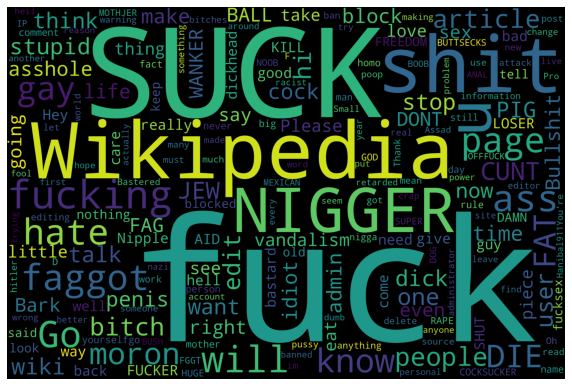

threat comment:


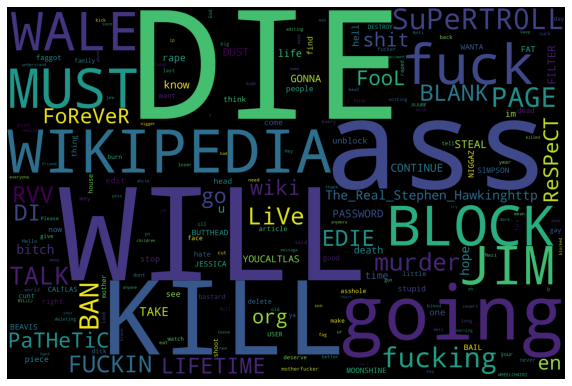

In [ ]:
toxic_corpus = df_train.loc[df_train['toxic'] == 1]
toxic_corpus = toxic_corpus["comment_text"].tolist()

threat_corpus = df_train.loc[df_train['threat'] == 1]
threat_corpus = threat_corpus["comment_text"].tolist()


print("Toxic comment:")
print()
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(toxic_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()

print()
print("threat comment:")
print()
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(threat_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()


## Labels distribution
Now, let's take a look at the distribution of the labels in the Toxic Comment Challenge dataset:
-  The label distribution is an essential aspect of any classification problem as it determines the class imbalance and helps in understanding the problem's complexity. 
- A thorough analysis of the label distribution can help in developing appropriate strategies for data preprocessing, model selection, and evaluation. 
- In this case, an imbalanced distribution of the toxic comments can pose significant challenges in identifying and categorizing the different types of toxic comments accurately. 

Therefore, it is crucial to examine the label distribution in detail before proceeding with any further analysis.

## Labels distribution in train set 

In [ ]:
for label in df_train.columns[2:]:
    print(df_train[label].value_counts(), '\n')

0    144277
1     15294
Name: toxic, dtype: int64 

0    157976
1      1595
Name: severe_toxic, dtype: int64 

0    151122
1      8449
Name: obscene, dtype: int64 

0    159093
1       478
Name: threat, dtype: int64 

0    151694
1      7877
Name: insult, dtype: int64 

0    158166
1      1405
Name: identity_hate, dtype: int64 



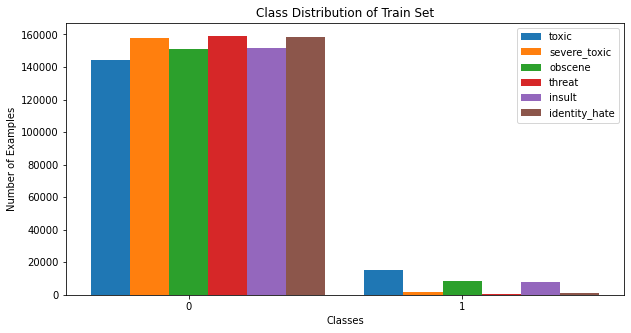

In [ ]:
# Get the class distribution for each column
class_distributions = []
for i in range(2, 8):
    class_distributions.append(df_train.iloc[:, i].value_counts())

# Create a combined bar chart
labels = class_distributions[0].index
num_columns = len(class_distributions)
width = 1 / (num_columns + 1)

fig, ax = plt.subplots(figsize=(10, 5))

for i, class_dist in enumerate(class_distributions):
    x = np.arange(len(labels)) + (i + 1) * width
    bars = ax.bar(x, class_dist, width, label=df_train.columns[i+2])

ax.set_ylabel('Number of Examples')
ax.set_xlabel('Classes')
ax.set_title('Class Distribution of Train Set')
ax.set_xticks(x - width * (num_columns / 2))
ax.set_xticklabels(labels)
ax.legend()

plt.show()


## Comparing the labels distribution between train and test set

- In the context of the Toxic Comment Challenge dataset, which contains comments labeled with various degrees of toxicity, it is crucial to ensure that the same proportion of each label is present in both the train and test set. This is because if, for example, the train set has a higher proportion of toxic comments than the test set, then the model may become biased towards identifying comments as toxic, even if they are not.

- However, as expected, the organizers of the competition prepared the train and test sets to have a similar label distribution to ensure a fair and meaningful evaluation of the models submitted by participants.

In [ ]:
labels = df_train.columns[2:]
# Compute the class distribution for the train set
train_class_distribution = df_train.iloc[:, 2:].sum()

# Compute the class distribution for the test set
test_class_distribution = df_test.iloc[:, 2:].sum()

print('Positive labels distribution in train set in percentage (%)')
print(round(train_class_distribution/df_train.shape[0]*100,2).sort_values(ascending = False))
print()
print(print('Positive labels distribution in test set in percentage (%)'))
print(round(test_class_distribution/df_test.shape[0]*100,2).sort_values(ascending = False))

Positive labels distribution in train set in percentage (%)
toxic            9.58
obscene          5.29
insult           4.94
severe_toxic     1.00
identity_hate    0.88
threat           0.30
dtype: float64

Positive labels distribution in test set in percentage (%)
None
toxic            9.52
obscene          5.77
insult           5.36
identity_hate    1.11
severe_toxic     0.57
threat           0.33
dtype: float64


## Distribution among only the positive labels

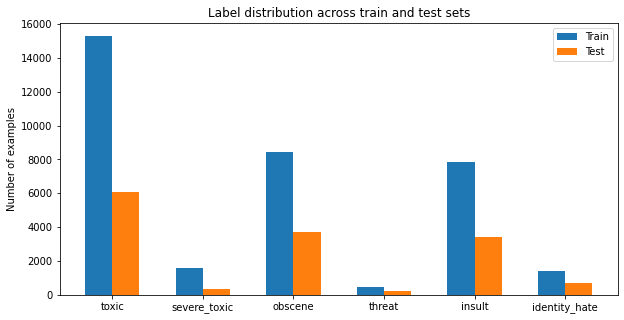

In [ ]:
train_data = [train_class_distribution[label] for label in labels]
test_data = [test_class_distribution[label] for label in labels]

# plot the bar chart
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 5))
train_bars = ax.bar(x - width/2, train_data, width, label='Train')
test_bars = ax.bar(x + width/2, test_data, width, label='Test')

# add labels, title and legend
ax.set_ylabel('Number of examples')
ax.set_title('Label distribution across train and test sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# display the plot
plt.show()

In [ ]:
train_class_distribution.sort_values(ascending = False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [ ]:
print('Distribution among only positive labels in train set in percentage (%)')
print(round(train_class_distribution/train_class_distribution.sum()*100,2).sort_values(ascending = False))
print()
print('Distribution among only positive labels in test set in percentage (%)')
print(round(test_class_distribution/test_class_distribution.sum()*100,2).sort_values(ascending = False))

Distribution among only positive labels in train set in percentage (%)
toxic            43.58
obscene          24.07
insult           22.44
severe_toxic      4.54
identity_hate     4.00
threat            1.36
dtype: float64

Distribution among only positive labels in test set in percentage (%)
toxic            42.01
obscene          25.46
insult           23.64
identity_hate     4.91
severe_toxic      2.53
threat            1.46
dtype: float64


## Recap
The analysis of the distribution of the target labels has highilited the following aspects: 
- Firstly, it is true that the dataset is unbalanced, in the sense that the majority of the comments are labeled as non-toxic (i.e., negative class), while a relatively small proportion of comments are labeled as one or more of the toxic categories (i.e., positive class). This means that the dataset has a class imbalance problem, which can affect the performance of classification models, particularly for the minority class.

- Secondly, within the positive class, there is also some degree of imbalance among the different toxic categories. For example, some categories like `toxic` and `insult` have many more examples than others like `threat` and `identity hate`. This means that a model trained on this dataset may be biased towards the more frequent categories and may perform worse on the rarer categories.

<a id='section04'></a>
# 4. Text preprocessing
In the current Challenge, text preprocessing is especially important due to the nature of the task. Toxic comments can take many different forms and contain a variety of words and phrases that may not be immediately recognizable as toxic. Preprocessing can help to standardize the text data, remove noise and irrelevant information, and ensure that the models are trained on a consistent and clean dataset.



---
***NOTE*** 

*It is important to note that text preprocessing steps have been applied only to the RNN models in this task. This is because BERT model is based on a powerful attention mechanism that allows them to effectively handle noise and irrelevant information in the input text. As such, additional preprocessing steps may not provide much benefit when working with BERT model. Therefore, the text preprocessing steps outlined in this section should be considered only for Model I and Model II, which are based on RNN architectures.*

---

## 1st phase - Text normalization
First of all, I decided to normalize the text data since comments from online forums usually contain inconsistent language, use of special characters in place of letters (e.g. @rgument), as well as the use of numbers to represent letters (e.g. n0t). To tackle such inconsistencies in data, I decided to eploit `regex` library. The normalization phase can be divided into two steps: 

1. I created a dictionary (`RE_PATTERNS`) containing common representations of cuss words which are frequently found on online forums or social media platforms. 

2. I defined the function `clean_text`.

The function has three boolean arguments that determine which cleaning operations are applied:

- `remove_repeat_text`: If set to True, this will remove repeating characters in the text, such as "sooooo" becoming "so".
- `remove_patterns_text`: If set to True, this will replace any specific patterns of text with a specified target. The patterns and their corresponding targets are defined in a dictionary called RE_PATTERNS.
- `is_lower`: If set to True, this will convert all text to lowercase.

The cleaning operations that are always applied include:

- Replacing newline characters with spaces
- Removing any non-alphanumeric characters (except spaces)
- Removing any numbers
- Removing any extra spaces
- Removing any non-ASCII characters

These operations have been apllied both to train and test sets.

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  # Replacing newline characters with spaces
  text = str(text).replace("\n", " ")

  # Removing any non-alphanumeric characters (except spaces)
  text = re.sub(r'[^\w\s]',' ',text)

  # Removing any numbers
  text = re.sub('[0-9]',"",text)

  # Removing any extra spaces
  text = re.sub(" +", " ", text)

  # Removing any non-ASCII characters
  text = re.sub("([^\x00-\x7F])+"," ",text)
  
  return text 

In [ ]:
df2_train = df_train.copy()
df2_test = df_test.copy()
df2_train['comment_text']= df_train['comment_text'].apply(lambda x: clean_text(x))
df2_test['comment_text'] = df_test['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
df_train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df2_train.comment_text[0]

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now '

In [ ]:
df_test['comment_text'][3]

'" \n\n It says it right there that it IS a type. The ""Type"" of institution is needed in this case because there are three levels of SUNY schools: \n -University Centers and Doctoral Granting Institutions \n -State Colleges \n -Community Colleges. \n\n It is needed in this case to clarify that UB is a SUNY Center. It says it even in Binghamton University, University at Albany, State University of New York, and Stony Brook University. Stop trying to say it\'s not because I am totally right in this case."'

In [ ]:
df2_test['comment_text'][3]

' it says it right there that it is a type the type of institution is needed in this case because there are three levels of suny schools university centers and doctoral granting institutions state colleges community colleges it is needed in this case to clarify that ub is a suny center it says it even in binghamton university university at albany state university of new york and stony brook university stop trying to say it s not because i am totally right in this case '

## 2nd phase - stopwords removal and lemmatization
The second stage of the text preprocessing involves instead the removal of the stopwords and the lemmatization of each token in both train and test sets:
- Stop words are words that are commonly used but do not carry much meaning on their own, such as "the" and "and". Removing these words can help to simplify the text and improve model performance.
- lemmatization, insetad, is the process of reducing words to their base form (or lemma). For example, the word "running" could be reduced to its base form "run". Lemmatization can help to normalize the text and reduce the number of unique words that a model needs to learn.

To accomplish these two operations I exploited the `NLTK` library:


- The `stopwords` module from NLTK contains a list of common English stop words that can be removed from text during preprocessing. 
- The `WordNetLemmatizer` class from NLTK is used to perform lemmatization

The preprocess_text function tokenizes the input text using word_tokenize from NLTK. It then removes stop words using the stopwords module and lemmatizes the remaining tokens using WordNetLemmatizer. Finally, it joins the lemmatized tokens back into a string and returns the preprocessed text.



In [ ]:
df3_train = df2_train.copy()
df3_test = df2_test.copy()

In [ ]:
# Initialize NLTK objects
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    preprocessed_text = " ".join(lemmatized_tokens)
    
    return preprocessed_text

# Apply the preprocessing function to the 'comment_text' column
df3_train['comment_text'] = df2_train['comment_text'].apply(preprocess_text)
df3_test['comment_text'] = df2_test['comment_text'].apply(preprocess_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df2_train['comment_text'][3]

' more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good_article_nominations transport '

In [ ]:
df3_train['comment_text'][3]

'make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipedia good_article_nominations transport'

## 3th phase - Text vectorization
- This is an important preprocessing step when working with text data in machine learning because it allows the text data to be transformed into numerical data that can be used as input to machine learning models.

- One common technique for vectorizing text is through tokenization, which involves breaking the text into smaller units called tokens, such as words or phrases. Once tokenized, these units can then be mapped to numerical values to create vector representations of the text.

- In this context, the Keras `Tokenizer` class provides a useful tool for tokenizing and vectorizing text data. By using the `fit_on_texts()` method of the Tokenizer object, the internal vocabulary of the tokenizer can be updated based on the frequency of each word in the text data. 

- It is important to **fit the tokenizer only on the training set** because we want to learn the vocabulary and the word index based on the training data. If we fit the tokenizer also on the test set, we would be introducing bias into our model. The model would have knowledge of the test set and could potentially overfit to it, resulting in poorer performance on unseen data.

- After fitting the tokenizer on the training data, we can use `texts_to_sequences()` method to convert the texts, in both the training and test data, to sequences of integers representing the token indices of the words in the original text. This ensures that the same vocabulary is used for both the training and test data, which is important for the model to generalize well to new data.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df3_train['comment_text'].values)

In [ ]:
word_index = tokenizer.word_index
NUM_FEATURES = len(word_index)
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  158504


In [ ]:
word_index

{'article': 1,
 'page': 2,
 'wikipedia': 3,
 'talk': 4,
 'one': 5,
 'please': 6,
 'would': 7,
 'like': 8,
 'see': 9,
 'source': 10,
 'think': 11,
 'also': 12,
 'know': 13,
 'time': 14,
 'people': 15,
 'user': 16,
 'edit': 17,
 'use': 18,
 'make': 19,
 'may': 20,
 'image': 21,
 'get': 22,
 'say': 23,
 'thanks': 24,
 'need': 25,
 'name': 26,
 'link': 27,
 'even': 28,
 'good': 29,
 'want': 30,
 'well': 31,
 'information': 32,
 'way': 33,
 'could': 34,
 'u': 35,
 'comment': 36,
 'deletion': 37,
 'go': 38,
 'editor': 39,
 'section': 40,
 'question': 41,
 'help': 42,
 'thing': 43,
 'first': 44,
 'wp': 45,
 'fact': 46,
 'new': 47,
 'look': 48,
 'work': 49,
 'point': 50,
 'editing': 51,
 'fuck': 52,
 'discussion': 53,
 'right': 54,
 'edits': 55,
 'thank': 56,
 'made': 57,
 'many': 58,
 'much': 59,
 'used': 60,
 'really': 61,
 'find': 62,
 'take': 63,
 'reference': 64,
 'deleted': 65,
 'read': 66,
 'add': 67,
 'list': 68,
 'since': 69,
 'change': 70,
 'someone': 71,
 'reason': 72,
 'wiki': 73,


In [ ]:
list_tokenized_train = tokenizer.texts_to_sequences(df3_train['comment_text'].values)
list_tokenized_test = tokenizer.texts_to_sequences(df3_test['comment_text'].values)

In [ ]:
print(list_tokenized_train[:3])

[[468, 55, 57, 541, 3878, 9873, 620, 230, 115, 5500, 2208, 2554, 47, 1006, 10034, 2417, 6, 144, 180, 4, 2, 69, 2937], [13745, 967, 423, 2568, 3925, 2356, 24, 4, 812, 100], [292, 298, 61, 153, 17, 164, 239, 1986, 377, 386, 32, 477, 55, 253, 4, 2, 122, 279, 2080, 600, 342]]


In [ ]:
print(list_tokenized_test[:3])

[[56, 891, 11, 906, 7, 248, 96, 53], [872, 370, 130, 2887], [1033, 13282, 175, 67, 714, 61, 86, 33, 15, 13282, 1117, 203, 714, 4934, 15538, 892, 1190, 2426, 154, 881, 440, 185, 5871, 1343, 83, 181, 1234, 2934, 1704, 3565, 9074, 557, 12847, 7645, 1, 685, 640, 247]]


## 4th phase - Padding 
- Padding involves adding zeros or other placeholder values to the end of shorter sequences to make all sequences in a dataset of equal length, either by padding them to the length of the longest sequence in the dataset or to a fixed length specified by hand. This is important because deep learning model such as Recurrent Neural Networks (RNNs) or Transformers (e.g. BERT) require inputs of a fixed size.
Padding ensures that all sequences have the same length, allowing these models to process them in a consistent manner. 

- While Tensorflow Hub provides a convenient `preprocess()` function for preparing text data for BERT models, when working with RNNs, we typically need to use the `pad_sequences()` function from Keras to pad the sequences to a fixed length.

- However, the fixed length can be considerd as a hyperparamter and we need to choose carefully this value. In order to make an informed decision, I decided to plot the distribution of comments within the dataset.

- Upon inspection, it became apparent that 98% of the comments had a length of less than 203 words. Consequently, I chose to set the fixed length of the input sequences to 200.

- It is important to note that any input sequences longer than 200 words will be truncated to this length.

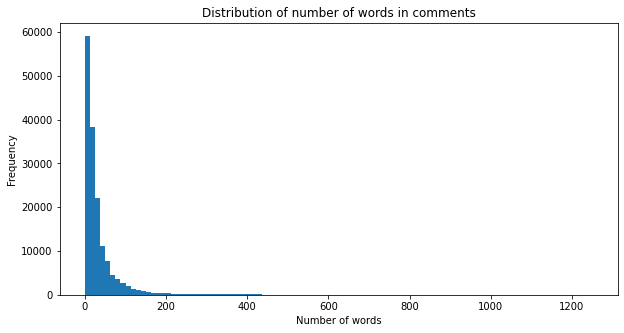

In [ ]:
import matplotlib.pyplot as plt

# Count the number of words in each comment
lengths = df3_train['comment_text'].str.split().apply(len)

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(lengths, bins=100)
ax.set_xlabel('Number of words')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of number of words in comments')
plt.show()


In [ ]:
lengths = df3_train['comment_text'].str.split().apply(len)
percentile_98 = np.percentile(lengths, 98)
percentile_98

203.0

In [ ]:
MAX_LENGTH = 200

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
X_test  = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')

In [ ]:
X_train

array([[  468,    55,    57, ...,     0,     0,     0],
       [13745,   967,   423, ...,     0,     0,     0],
       [  292,   298,    61, ...,     0,     0,     0],
       ...,
       [26741,  6327,  4454, ...,     0,     0,     0],
       [   48,     8,   125, ...,     0,     0,     0],
       [   61,    11,   159, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print("Shape train set:", X_train.shape)

Shape train set: (159571, 200)


In [ ]:
X_test

array([[   56,   891,    11, ...,     0,     0,     0],
       [  872,   370,   130, ...,     0,     0,     0],
       [ 1033, 13282,   175, ...,     0,     0,     0],
       ...,
       [ 1958,    30,   715, ...,     0,     0,     0],
       [ 5287,  5511,   710, ...,     0,     0,     0],
       [14251, 24372,  2988, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print("Shape test set:", X_test.shape)

Shape test set: (63978, 200)


In [ ]:
y_train = df_train[df_train.columns[2:]].values
y_test = df_test[df_test.columns[2:]].values

In [ ]:
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
y_train.shape

(159571, 6)

In [ ]:
y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
y_test.shape

(63978, 6)

## Preparing input pipeline (Model I and Model II)
In order to train a machine learning model on this large dataset, it is important to use an input pipeline that can efficiently preprocess and transform the data into tensors that the model can understand. An input pipeline can help speed up training, reduce memory usage, and improve model performance by using techniques such as caching, shuffling, batching, and prefetching. Therefore, creating a robust and efficient input pipeline is crucial when working with large datasets like the Comment Toxicity Classification challenge dataset.

Here's a breakdown of what each line does:

- `ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))`: This line creates a `tf.data.Dataset` object from the input data `X_train` and `y_train`. The from_tensor_slices method creates a dataset where each element is a pair of corresponding elements from `X_train` and `y_train`.
- `ds_train = ds_train.cache()`: This line adds a cache to the dataset. Caching can speed up training by allowing data to be loaded more quickly from memory rather than from disk.
- `ds_train = ds_train.shuffle(160000)`: This line shuffles the dataset. Shuffling can improve model performance by preventing the model from becoming biased towards certain examples that may appear early in the dataset.
- `ds_train = ds_train.batch(32)`: This line creates batches of 32 examples from the shuffled dataset. Batching can make training more efficient by allowing the model to process multiple examples at once.
- `ds_train = ds_train.prefetch(16)`: This line prefetches 16 batches of data. Prefetching can further improve training efficiency by allowing the model to retrieve data from memory while it's still processing previous batches.

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(160000)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(16) # helps bottlenecks

In [ ]:
# let's see how a batch looks like
batch_X, batch_y = ds_train.as_numpy_iterator().next()

In [ ]:
print(batch_X)
print("\n", batch_X.shape)

[[    6    92   187 ...     0     0     0]
 [64848  1382   501 ...     0     0     0]
 [  872   470   656 ...     0     0     0]
 ...
 [  218     6   131 ...     0     0     0]
 [  121   401 21613 ...     0     0     0]
 [  346   489   217 ...     0     0     0]]

 (32, 200)


In [ ]:
print(batch_y)
print("\n", batch_y.shape)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

 (32, 6)


<a id='section05'></a>
# 5. Train, validation and test split
- To prepare the Comment Toxicity Classification challenge dataset for model training, I split the available training data into two sets: a training set and a validation set. Specifically, I allocated 80% of the training data for the training set, while the remaining 20% was reserved for the validation set. This allowed me to evaluate the model's performance during training and make adjustments as necessary.

- Finally, I applied the same input pipeline used for these sets to the test set. This ensured that the test data was preprocessed consistently with the training and validation sets, enabling a fair and accurate evaluation of the model's performance.

In [ ]:
train = ds_train.take(int(len(ds_train)*.8))
val = ds_train.skip(int(len(ds_train)*.8)).take(int(len(ds_train)*.2))

In [ ]:
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.cache()
test = test.batch(32)
test = test.prefetch(16) # helps bottlenecks

In [ ]:
print("Number of batches in train set:", len(train))
print("Number of batches in validatiom set:", len(val))
print("Number of batches in test set:", len(test))

Number of batches in train set: 3989
Number of batches in validatiom set: 997
Number of batches in test set: 2000


# Callbacks
- The `EarlyStopping` callback is used to stop the training process when the monitored validation loss metric has stopped improving for a certain number of epochs, specified by the patience parameter. It helps prevent overfitting and saves time by stopping the training process early.

- The `ReduceLROnPlateau` callback reduces the learning rate when the monitored validation loss metric has stopped improving for a certain number of epochs, specified by the patience parameter. This helps to prevent the network from getting stuck in a local minimum and can help the model to converge to a better solution.

- However, it's worth noting that these callbacks were not used in the training process as they were not needed. This may happen in cases where the neural network converges quickly or does not overfit the data. It's always a good practice to keep these callbacks ready in case they are needed to ensure optimal performance.

In [ ]:
# Set up EarlyStopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True
)

# Set up ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
)

callbacks = [earlystop_callback, reduce_lr_callback]

<a id='section06'></a>
# 6. Model I - Baseline

## Architecture
- A bidirectional LSTM layer was chosen as baseline mdoel. Bidirectional LSTM is a type of recurrent neural network that can capture the context of input sequences in both forward and backward directions. This is a suitable choice for the Toxic Comment Challenge dataset, where the context of the comment is crucial in determining its level of toxicity.

- Various other architectures with either multiple LSTM layers or multiple dense layers were tried, but the simpler architecture with a single bidirectional LSTM layer and a single dense output layer with sigmoid activation was found to be the most effective.

- In terms of the embeddings used, experiments were carried out with embeddings of 128, 200, and 300 dimensions. However, it was found that using embeddings of 128 dimensions gave the same results as the other dimensions, while also allowing for faster training time. Therefore, the final choice was to use 128-dimensional embeddings.

The final model architecture consists of four layers:

1. An embedding layer, created using `Embedding()`. It maps each word in a vocabulary to a unique vector of fixed size, in this case 128 dimensions. The vectors are learned during training and are optimized to capture the semantic relationships between words in the input data. Words that are semantically similar are mapped to vectors that are close together in the vector space. It is important to notice that in this case we are learning embeddings from scratch.
2. A bidirectional LSTM layer, created using `Bidirectional(LSTM())`. This layer processes the input sequence in both forward and backward directions to capture context from both directions.
3. `Dropout layer` with a dropout rate of 0.2. Dropout randomly sets a fraction of the input units to 0 during training, forcing the network to learn more robust representations.
4. A dense output layer with sigmoid activation, created using `Dense()`. This layer outputs a probability for each of the six labels in the dataset.

## Loss function
Although there are similarities in the approaches used for multiclass and multilabel classification problems, there are also some differences due to the nature of these problems. The key difference between the two lies in the loss function employed. In multilabel classification, the loss function evaluates the probability of each category independently, rather than in comparison to other categories. This necessitates the use of `Binary Cross-Entropy (BCE)` rather than Sparse Categorical Cross-Entropy (SCCE) or Categorical Cross-Entropy (CCE) for the loss function. Moreover, to address this point, the `sigmoid function` is used for output activation instead of Softmax.

## Optimizer
For the optimizer, I selected the Adam optimizer with a default learning rate of 1e-3.

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
# Create the embedding layer 
model.add(Embedding(NUM_FEATURES+1, 128))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, activation='tanh', dropout = 0.2)))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         20288640  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 20,553,350
Trainable params: 20,553,350
Non-trainable params: 0
_________________________________________________________________


## Training the model
The best number of epochs turned out to be 5. In fact, 
training for longer may result in poorer performance on the test set, despite an increase in performance on the validation set. The reason behind this is that the Jigsaw Toxic Comment Classification Challenge dataset was trained on comments from Wikipedia, which may not perfectly represent the patterns and characteristics of comments from real-world applications. The test data, on the other hand, includes comments from a variety of sources, such as social media and news articles, which may have different distributions of toxic comments. As a result, the model, if trainend for too many epochs, may overfit to the patterns and characteristics of the Wikipedia data and fail to generalize well to the test data.

In [ ]:
history = model.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

Epoch 1/5


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


3490/3490 [==============================] - 603s 170ms/step - loss: 0.0628 - f1_score: 0.3890 - val_loss: 0.0432 - val_f1_score: 0.4622 - lr: 0.0010
Epoch 2/5
3490/3490 [==============================] - 518s 148ms/step - loss: 0.0434 - f1_score: 0.4586 - val_loss: 0.0361 - val_f1_score: 0.4650 - lr: 0.0010
Epoch 3/5
3490/3490 [==============================] - 502s 144ms/step - loss: 0.0376 - f1_score: 0.5350 - val_loss: 0.0321 - val_f1_score: 0.5750 - lr: 0.0010
Epoch 4/5
3490/3490 [==============================] - 497s 142ms/step - loss: 0.0331 - f1_score: 0.5892 - val_loss: 0.0277 - val_f1_score: 0.6220 - lr: 0.0010
Epoch 5/5
3490/3490 [==============================] - 514s 147ms/step - loss: 0.0285 - f1_score: 0.6446 - val_loss: 0.0233 - val_f1_score: 0.7231 - lr: 0.0010


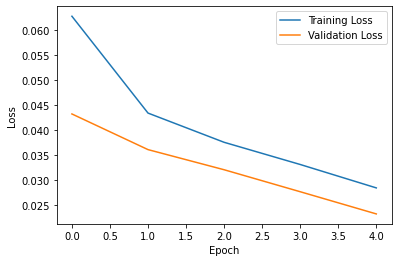

In [ ]:
# Plot the loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

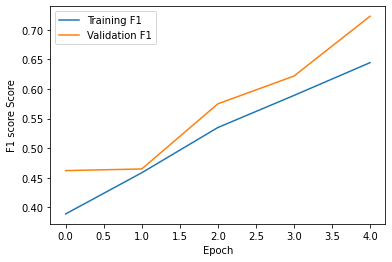

In [ ]:
# Plot the F1 macro score on the training and validation sets
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 score Score')
plt.legend()
plt.show()

## Evaluating the model

In [ ]:
# restore the best weights for the baseline model
model.load_weights('drive/MyDrive/toxicity_model.h5')

In [ ]:
from sklearn.metrics import classification_report
# Predict the labels for all batches in your test dataset
y_pred = []
y_true = []
label_names = df_train.columns[2:]

for X_batch, y_batch in test:
    y_pred_batch = model.predict(X_batch)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch)

# Convert the predicted and true labels into numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 [==============================] - 1s 650ms/step


## Adjusting the threshold
- The output of the sigmoid activation function used in the final layer of the model produces probabilities for each of the labels in the dataset. These probabilities represent the model's confidence that a given input belongs to each of the classes.

- However, when dealing with unbalanced data as in this case, using the default threshold of 0.5 might not be appropriate for evaluating the model's performance. In other words, the model might be biased towards predicting the majority class, which could lead to poor performance on the minority classes. In such cases, it might be necessary to adjust the threshold to a value that maximizes the performance of the model on the specific problem at hand. In this case the optimal threshold resulted to be 0.35.

In [ ]:
threshold = 0.35
y_pred_thresh = (y_pred >= threshold).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_thresh, target_names=label_names, zero_division = 1)
print(report)

               precision    recall  f1-score   support

        toxic       0.53      0.84      0.65      6090
 severe_toxic       0.29      0.63      0.40       367
      obscene       0.60      0.79      0.68      3691
       threat       0.46      0.44      0.45       211
       insult       0.61      0.69      0.64      3427
identity_hate       0.58      0.54      0.56       712

    micro avg       0.55      0.77      0.64     14498
    macro avg       0.51      0.65      0.56     14498
 weighted avg       0.56      0.77      0.64     14498
  samples avg       0.92      0.97      0.90     14498



The results of the inference show that the model performed quite well on the dataset, achieving a macro-averaged F1 score of 0.56. This is a notable achievement considering the semplicity of the model adopted and the complexity of the dataset, which contains various types of toxic comments that are often hard to distinguish. The model performed particularly well in identifying obscene comments, achieving an F1 score of 0.68, followed by toxic and insult comments with F1 scores around 0.65. However, it struggled with the rare labels such as severe toxic and threat, which had lower F1 scores. Overall, the model's performance demonstrates the effectiveness of the chosen architecture even if further improvements are necessary, particularly for the rare labels.

<a id='section07'></a>
# 7. Model II - Glove
In the previous experiments, we trained a deep learning model to identify toxic language in text by learning embedding vectors from scratch. However, this approach can be computationally expensive and time-consuming, and the resulting embeddings may not capture the full semantic meaning of the words. In this experiment, we will use pre-trained word embeddings from GloVe (Global Vectors for Word Representation) to compare their performance with the embeddings learned from scratch. GloVe is a widely used method for creating word embeddings based on global co-occurrence statistics, and it has been shown to perform well on a variety of natural language processing tasks. By comparing the performance of the two approaches, we can gain insights into the benefits and limitations of using pre-trained word embeddings for toxic language detection.

## Loading Glove's embeddings
- `Gensim` is an open-source Python library for natural language processing that provides a simple interface for downloading and working with pre-trained word embeddings from various sources, including GloVe, FastText, and Word2Vec.

- One of the main advantages of using Gensim to download GloVe embeddings is that it automates the process of downloading and loading the pre-trained model, making it faster and easier to use than manually downloading the embeddings from a website and loading them into memory.

- I consireder the `glove-wiki-gigaword-300` model. It is a specific implementation of the GloVe algorithm that was trained on a combination of the Wikipedia 2014 and Gigaword 5 corpora, which are large collections of web pages and newswire articles, respectively. The resulting embeddings consist of 300 dimensions which can capture a rich array of semantic and syntactic information about the word

In [ ]:
import gensim.downloader as api
glove = api.load('glove-wiki-gigaword-300')
print("Found %s word vectors." % len(glove.vectors))

[==================================================] 100.0% 376.1/376.1MB downloaded
Found 400000 word vectors.


## Embedding matrix
Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in the corresponding tokenizer's vocabulary.

## Out-Of-Vocabulary words: Random Embedding
The Out-Of-Vocabulary words (OOVs) are words which do not belong to the GloVe's vocabulary. A random embedding approach was used to handle them. This approach generates a random vector of 300 values for each OOV, with values uniformly distributed between -0.5 and 0.5.

In [ ]:
def get_embedding_matrix(length_voc, word_index, embedding_dim = 300 ):
    num_tokens = length_voc + 1
    hits = 0
    misses = 0
    oov_embedded = []
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        if not(word in oov_embedded):
            try: 
                embedding_vector = glove.get_vector(word)
                embedding_matrix[i] = embedding_vector
                hits += 1
            except:
                # handling oovs with random embeddings
                embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                misses += 1
                oov_embedded.append(word)

    return embedding_matrix, hits, misses, oov_embedded

In [ ]:
# creation of vocabulary for the training set and extraction of his OOVs.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df3_train.comment_text)
word_index_train = tokenizer.word_index

print(len(word_index_train.keys()))
embedding_matrix_train, hits, misses, oov_embedded = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
#print(oov_embedded)
print("Embedding matrix shape: {}".format(embedding_matrix_train.shape))
print("Converted %d words (%d misses)" % (hits, misses))

158504
Embedding matrix shape: (158505, 300)
Converted 83674 words (74830 misses)


In this process, we have converted 83674 words from our vocabulary into their respective GloVe embeddings, while 74,830 words were assigned random embeddings. Our final embedding matrix has a shape of (158505, 300), where each row corresponds to a word in our vocabulary, and each column corresponds to a feature in the embedding space.

So now we are ready to create the embedding layer to give in input to our model.

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, TimeDistributed, GRU
import keras

embedding_layer = Embedding(
    input_dim = embedding_matrix_train.shape[0],
    output_dim = 300,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix_train),
    trainable = False,
    mask_zero = True
)

## Architecture
We used the same model architecture as the baseline, but instead of training embeddings from scratch, we initialized the embedding layer with pre-trained GloVe embeddings.

In [ ]:
tf.keras.backend.clear_session()
model_glove = Sequential()
# Create the embedding layer with Glove's embeddings
model_glove.add(embedding_layer)
# Bidirectional LSTM Layer
model_glove.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
# Final layer 
model_glove.add(Dense(6, activation='sigmoid'))

In [ ]:
model_glove.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])

In [ ]:
model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         47551500  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 47,992,338
Trainable params: 440,838
Non-trainable params: 47,551,500
_________________________________________________________________


## Training the model
For this second model, we again chose to train the model for only 5 epochs, due to the same reasons as explained in the baseline model.

In [ ]:
history = model_glove.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

Epoch 1/5


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


3989/3989 [==============================] - 161s 37ms/step - loss: 0.0596 - f1_score: 0.4495 - val_loss: 0.0463 - val_f1_score: 0.5646 - lr: 0.0010
Epoch 2/5
3989/3989 [==============================] - 145s 36ms/step - loss: 0.0460 - f1_score: 0.5661 - val_loss: 0.0394 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 3/5
3989/3989 [==============================] - 139s 35ms/step - loss: 0.0420 - f1_score: 0.6204 - val_loss: 0.0360 - val_f1_score: 0.6963 - lr: 0.0010
Epoch 4/5
3989/3989 [==============================] - 151s 38ms/step - loss: 0.0386 - f1_score: 0.6601 - val_loss: 0.0339 - val_f1_score: 0.7181 - lr: 0.0010
Epoch 5/5
3989/3989 [==============================] - 149s 37ms/step - loss: 0.0353 - f1_score: 0.6960 - val_loss: 0.0281 - val_f1_score: 0.7776 - lr: 0.0010


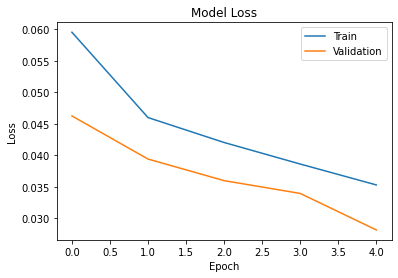

In [ ]:
# Plot the loss and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

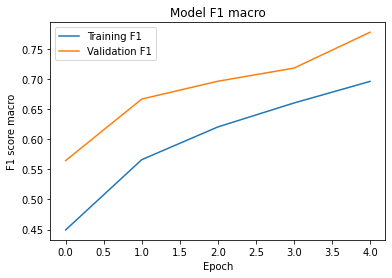

In [ ]:
# Plot the F1 macro score on the training and validation sets
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.title('Model F1 macro')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
plt.show()

## Evaluating the model

In [ ]:
# restoring the best weights for Glove model
model_glove.load_weights('drive/MyDrive/toxicity_glove.h5')

In [ ]:
from sklearn.metrics import classification_report
# Predict the labels for all batches in your test dataset
y_pred = []
y_true = []
label_names = df_train.columns[2:]

for X_batch, y_batch in test:
    y_pred_batch = model_glove.predict(X_batch)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch)

# Convert the predicted and true labels into numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 [==============================] - 3s 3s/step


In [ ]:
threshold = 0.5
y_pred_thresh = (y_pred >= threshold).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_thresh, target_names=label_names, zero_division = 1)
print(report)

               precision    recall  f1-score   support

        toxic       0.54      0.87      0.67      6090
 severe_toxic       0.34      0.44      0.38       367
      obscene       0.60      0.77      0.68      3691
       threat       0.37      0.50      0.42       211
       insult       0.62      0.66      0.64      3427
identity_hate       0.65      0.42      0.51       712

    micro avg       0.57      0.76      0.65     14498
    macro avg       0.52      0.61      0.55     14498
 weighted avg       0.57      0.76      0.65     14498
  samples avg       0.92      0.98      0.90     14498



- The results show that the use of pre-trained embeddings resulted in a slight decrease in performance compared to using embeddings trained from scratch. Although the embeddings for the words in the vocabulary that are present in the pre-trained GloVe model are likely to be better, one possible explanation for this is that the pre-trained GloVe embeddings do not cover the entire vocabulary of our dataset, resulting in a significant number of Out-Of-Vocabulary (OOV) words (74830 out of 158505). These OOV words are then represented by random embeddings, which may not capture their actual meanings and negatively impact the performance of the model. This could explain why training the model from scratch, even though it takes longer, may be more effective in capturing the nuances of the dataset, as all the words in the vocabulary are accounted for and represented by meaningful embeddings.

- A possible solution to mitigate the issue of OOVs affecting the performance of the model is to fine-tune the GloVe embeddings on the vocabulary of the dataset, so that the model can learn the embedding representation of the OOV words. However, fine-tuning GloVe embeddings can be computationally expensive and may not result in a significant improvement in performance, so it is beyond the scope of this work. Nonetheless, it remains an interesting avenue for future research.

<a id='section08'></a>
# 8. Model III - BERT
- In order to further improve the performance of our model on the Jigsaw Toxic Comment Classification Challenge, I decided to explore the use of BERT (Bidirectional Encoder Representations from Transformers), a state-of-the-art language model that has been shown to achieve excellent results on a wide range of natural language processing tasks. BERT is based on the Transformer architecture, which enables it to capture bidirectional context information and produce highly accurate predictions for a variety of NLP tasks. By leveraging the power of BERT, we hope to be able to significantly improve the performance of our model and achieve even better results on this challenging task.

- To do this, we will make use of the TensorFlow Hub API, which provides access to a wide range of pre-trained models, including BERT. Specifically, we will use the `bert_en_uncased_L-12_H-768_A-12` model, which corresponds to the most common BERT-Base model. It has 12 layers of transformer blocks, 768 hidden units, and 110 million parameters. The "uncased" part of the name means that the model is case-insensitive, meaning that all words are treated as lowercase during training and inference. This is useful because it reduces the size of the vocabulary and can help improve performance on tasks with limited data.

- We will also use the corresponding pre-processing module `bert_en_uncased_preprocess`, which is necessary to properly format the input data for use with the BERT model. The code to select the BERT model and pre-processing module is shown below.

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model
Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:




In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As we can see, now we have the 3 outputs from the preprocessing that a BERT model would use:

1. `input_word_ids`: this array contains integer indices that represent the words in the input sentence. Each sentence is tokenized into a sequence of word pieces, and these indices refer to the vocabulary indices of those word pieces.
2. `input_mask`: this array specifies which word pieces in the `input_word_ids` array should be attended to by the model and which ones should be ignored. In particular, the input mask contains 1's for all the word pieces that should be attended to by the model and 0's for all the word pieces that should be ignored.
3. `input_type_ids`: this array specifies which tokens belong to the first sentence and which tokens belong to the second sentence (if there is a second sentence). For a single sentence classification task like ours, all the values in this array will be 0.

Another important point:

The input is **truncated to 128 tokens**. The number of tokens can be customized, but because of limited GPU resources at disposal it was not possible to consider 200 tokens as the previous models.


## Using the BERT model
Before putting BERT into your own model, let's take a look at its outputs. We will load it from TF Hub and see the returned values.
The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs.

However, for our fine-tuning task, we are interested only on the `pooled output` which is a fixed-size representation of the entire input sequence that summarizes the most important information in the text. 



In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92169887 -0.39353466 -0.53931785  0.6825625   0.43848515 -0.14021172
  0.87747127  0.26043358 -0.6311301  -0.9999658  -0.26320052  0.85105324]


## Defining the model
Now we will create the fine-tuned model. In this case, we will create a BERT model for multilabel text classification by adding a dropout layer and a dense layer. We use a dropout layer to prevent overfitting and a dense layer to perform the final classification.

Here is an explanation of each line of the code below:

1. `text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')`: This line defines an input layer that will take string input with a variable length.

2. `preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')`: This line creates a Keras layer using the BERT preprocessor module provided by TensorFlow Hub.

3. `encoder_inputs = preprocessing_layer(text_input)`: This line applies the preprocessor layer to the input text.

4. `encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')`: This line creates a Keras layer using the BERT encoder module provided by TensorFlow Hub. This layer is trainable, meaning its weights can be updated during training.

5. `outputs = encoder(encoder_inputs)`: This line applies the encoder layer to the preprocessed input to get the BERT outputs.

6. `net = outputs['pooled_output']`: This line extracts the pooled output from the BERT outputs. This output is a fixed-size representation of the input text that summarizes the most important information in the text.

7. `net = tf.keras.layers.Dropout(0.5)(net)`: This line adds a dropout layer with a rate of 0.5 to help prevent overfitting.

8. `net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)`: This line adds a dense layer with a sigmoid activation function and 6 units, which represents the output classes of the classifier.

9. `return tf.keras.Model(text_input, net)`: This line returns the Keras model that takes input from the `text_input` layer and outputs the classification results from the `net` layer.


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
tf.keras.backend.clear_session()
classifier_model = build_classifier_model()

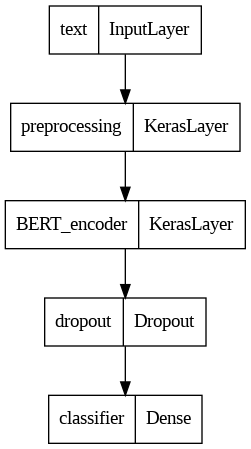

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Building data pipeline
As with the previous model, it is crucial to prepare an input pipeline for our data to ensure faster training of the model. However, in contrast to the previous models, the text is not preprocessed in this case as it will be handled by the preprocessing function of Tensorflow Hub.

In [ ]:
y = df_train[df_train.columns[2:]]
ds= tf.data.Dataset.from_tensor_slices((df_train['comment_text'], y))
ds = ds.cache()
ds = ds.shuffle(160000)
ds = ds.batch(32)
ds = ds.prefetch(16) 

In [ ]:
train_ds = ds.take(int(len(ds)*.8))
val_ds = ds.skip(int(len(ds)*.8)).take(int(len(ds)*.2))

In [ ]:
y_test = df_test[df_test.columns[2:]]
test= tf.data.Dataset.from_tensor_slices((df_test['comment_text'], y_test))
test = test.cache()
test = test.batch(32)
test = test.prefetch(16) 

## Optimizer
- To fine-tune our BERT model, we will use the same optimizer that BERT was originally trained with: the Adaptive Moments optimizer (Adam). This optimizer minimizes the prediction loss and performs regularization by weight decay, which is also referred to as `AdamW`.

- To determine the learning rate (init_lr), we will follow the same schedule as BERT pre-training. This involves a linear decay of a notional initial learning rate, preceded by a linear warm-up phase over the first 10% of training steps (num_warmup_steps). As recommended in the BERT paper, the initial learning rate for fine-tuning is smaller than the pre-training learning rate and should be chosen from a set of values such as 5e-5, 3e-5, or 2e-5, based on performance on a validation set (3e-5 in this case).

In [ ]:
epochs = 4
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])

## Training the model

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
checkpoint_filepath = 'drive/MyDrive/tmp_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = [model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/4
3989/3989 [==============================] - 4057s 1s/step - loss: 0.0669 - f1_score: 0.4451 - val_loss: 0.0363 - val_f1_score: 0.5881
Epoch 2/4
3989/3989 [==============================] - 4036s 1s/step - loss: 0.0364 - f1_score: 0.6540 - val_loss: 0.0294 - val_f1_score: 0.6917
Epoch 3/4
3989/3989 [==============================] - 4034s 1s/step - loss: 0.0292 - f1_score: 0.7183 - val_loss: 0.0218 - val_f1_score: 0.7968
Epoch 4/4
3989/3989 [==============================] - 4037s 1s/step - loss: 0.0223 - f1_score: 0.7818 - val_loss: 0.0173 - val_f1_score: 0.8420


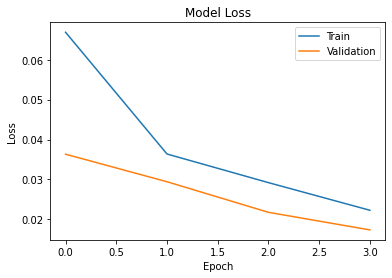

In [ ]:
# Plot the loss and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

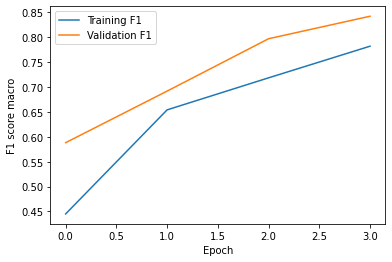

In [ ]:
# Plot the F1 macro score on the training and validation sets
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
plt.show()

## Evaluating the model

In [ ]:
# restoring the best weights for BERT model
model_glove.load_weights('drive/MyDrive/toxicity_bert.h5')

In [ ]:
from sklearn.metrics import classification_report
# Predict the labels for all batches in your test dataset
y_pred = []
y_true = []
label_names = df_train.columns[2:]

for X_batch, y_batch in test:
    y_pred_batch = classifier_model.predict(X_batch)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch)

# Convert the predicted and true labels into numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 [==============================] - 1s 771ms/step


In [ ]:
threshold = 0.5
y_pred_thresh = (y_pred >= threshold).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_thresh, target_names=label_names, zero_division = 1)
print(report)

               precision    recall  f1-score   support

        toxic       0.54      0.90      0.67      6090
 severe_toxic       0.34      0.56      0.42       367
      obscene       0.62      0.80      0.70      3691
       threat       0.51      0.70      0.59       211
       insult       0.66      0.75      0.70      3427
identity_hate       0.59      0.65      0.62       712

    micro avg       0.58      0.82      0.67     14498
    macro avg       0.54      0.73      0.62     14498
 weighted avg       0.58      0.82      0.68     14498
  samples avg       0.92      0.98      0.90     14498



The results of our text classification task demonstrate that using BERT allowed us to increase our performance considerably. Specifically, the F1 score improved from 0.55 and 0.56 with our previous models to 0.62 with the BERT model.

This improvement can be attributed to several factors: 
- The improvement in performance from our previous models to the BERT model can be attributed, in part, to the fact that transformers are a more powerful model architecture than RNNs. Unlike RNNs, transformers are not limited by the vanishing gradient problem, which can make it difficult for RNNs to learn dependencies over long sequences. Additionally, transformers are able to capture contextual information from across the entire input sequence, whereas RNNs process the sequence one element at a time in a fixed order.
- Moreover, BERT's fine-tuning capability allows for optimization of the model for specific downstream tasks, such as our text classification task. This can further improve performance. 

Overall, the results demonstrate the power of BERT for improving text classification performance.

<a id='section09'></a>
# 9. Comparison of models performance

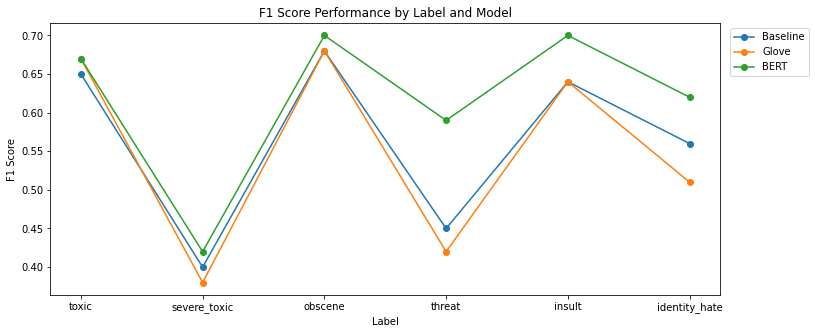

In [ ]:
import matplotlib.pyplot as plt

# define the labels and f1 scores for each model
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
f1_scores_model1 = [0.65, 0.40, 0.68, 0.45, 0.64, 0.56]
f1_scores_model2 = [0.67, 0.38, 0.68, 0.42, 0.64, 0.51]
f1_scores_model3 = [0.67, 0.42, 0.70, 0.59, 0.70, 0.62]

# create a list of x values for each label
x_values = list(range(len(labels)))

plt.figure(figsize=(12,5))
# plot the f1 scores for each model
plt.plot(x_values, f1_scores_model1, 'o-', label='Baseline')
plt.plot(x_values, f1_scores_model2, 'o-', label='Glove')
plt.plot(x_values, f1_scores_model3, 'o-', label='BERT')

# set the x-axis labels to the label names
plt.xticks(x_values, labels)

# add a legend
plt.legend()

# set the title and axis labels
plt.title('F1 Score Performance by Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1.14, 1), loc='upper right')
# display the plot
plt.show()

    

- The plot reveals that while the baseline model and Model II (Glove) exhibit comparable F1 scores across all labels, BERT outperforms both of them considerably in classifying the labels `threat`, `insult`, and `identity hate`. These labels are relatively rare, and BERT's ability to handle imbalanced data likely contributed to its superior performance. Notably, the label `threat` has the lowest support, with only 211 samples, yet BERT achieves an impressive F1 score of 0.59, compared to 0.42 and 0.45 for the other models. Similarly, the label `identity hate` presents a significant challenge, and in this regard, BERT outperforms the other models. Specifically, it achieves an F1 score that is approximately 10% higher than that of the baseline and Glove models. It's noteworthy that these improvements are particularly important for the rare labels, such as threat and identity hate, which have very low support in the dataset, making them more challenging to classify accurately.

- In contrast, all three models exhibit similar performance for the `toxic` and `severe toxic` labels, which may be due to the similarity between these categories. However, performing an error analysis would be necessary to uncover interesting insights in the results and identify areas for further model improvement.

<a id='section10'></a>
# 10. Conclusion and future work
- In conclusion, the toxic comment challenge dataset represents a challenging task for text classification due to the high level of toxicity in the comments and the imbalanced class ratio. In this notebook, we have explored three models for this task: a baseline model, a GloVe model, and a BERT model. The results show that BERT outperformed the other models in most of the categories, especially in the rare labels, such as threat and identity hate. The study also revealed that the performance of all three models was similar in toxic and severe toxic categories.

- Future work could focus on addressing the issue of imbalanced class ratios, which can significantly impact the model's performance in rare categories.

- Furthermore, exploring other transformer architectures such as RoBERTa or XLNet or BERT-Large could be considered to improve the model's performance further. These models have demonstrated superior performance on various NLP tasks, and they are designed with larger model sizes, more extensive pre-training, and advanced training techniques. Therefore, adopting these models should lead to better performance than the BERT-Base model used in this work. 

- In summary, the study highlights the effectiveness of BERT in multi-label text classification, especially in imbalanced datasets. Addressing the imbalanced data issue and exploring more advanced transformer models could improve the performance further more.

**Thank you!**